In [1]:
%matplotlib inline
import numpy as np
from scipy.stats import multivariate_normal, norm
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy

import h5py

import tqdm

from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_spd_matrix
from sklearn.metrics import roc_curve, auc

In [2]:
class Theta:
    def __init__(self, pi, mu, sigma):
        self.pi = pi
        self.mu = mu
        self.sigma = sigma

In [3]:
from sklearn.mixture import GaussianMixture
import numpy as np


class SDEM(GaussianMixture):
    def __init__(self, r, alpha, n_components=2, **kwargs):
        super().__init__(n_components=n_components, **kwargs)
        
        self.r = r
        self.alpha = alpha
        self.t = 0
        
        self.pi_list = []
        self.pi_bar_list = []
        self.means_list = []
        self.means_bar_list = []
        self.covariances_list = []
        self.covariances_bar_list = []
        
    def fit(self, X, y=None):
        super().fit(X, y)
        self.means_bar = np.copy(self.means_)
        self.covariances_bar = np.copy(self.covariances_)
        
    def update(self, x):
        """Employ SDEM algorithm."""
        
        # E-step for weights
        gamma = (1-self.alpha*self.r[self.t]) * self.predict_proba(x.reshape(1, -1)) + self.alpha*self.r[self.t]/self.weights_.shape[0]
        gamma = gamma.ravel()
        self.weights_ = (1-self.r[self.t])*self.weights_ + self.r[self.t]*gamma
        
        x = x.ravel()
        means, means_bar, covariances, covariances_bar = [], [], [], []
        for i, (w, m, cov) in enumerate(zip(self.weights_, self.means_bar, self.covariances_bar)):
            # E-step for mean and covariance
            m = (1-self.r[self.t])*m + self.r[self.t]*gamma[i]*x
            cov = (1-self.r[self.t])*cov + self.r[self.t]*gamma[i]*np.outer(x,x)
            means_bar.append(m)
            covariances_bar.append(cov)

            # M-step for mean and covariance
            m = m/w
            cov = cov/w - np.outer(m, m)
            means.append(m)
            covariances.append(cov)

        self.means_ = np.vstack(means) # \mu_i^{(t)} in the paper
        self.covariances_ = np.stack(covariances)
        self.means_bar = np.stack(means_bar)
        self.covariances_bar = np.stack(covariances_bar)
        
        self.pi_list.append(self.weights_)
        self.means_list.append(self.means_)
        self.covariances_list.append(self.covariances_)
        self.means_bar_list.append(self.means_bar)
        self.covariances_bar_list.append(self.covariances_bar)
        
        self.t += 1

In [4]:
def compute_tau(X, theta):
    N = X.shape[0]
    K = len(theta.pi)

    tau = np.zeros((N, K))
    for k in range(K):
        d_k = multivariate_normal(theta.mu[k], theta.sigma[k], allow_singular=True)
        for i in range(N):
            tau[i, k] = theta.pi[k] * d_k.pdf(X[i])
    tau /= np.sum(tau, axis=1, keepdims=True)
    
    return tau

In [5]:
def compute_stat(X, Z):
    K = Z.shape[0]
    D = X.shape[1]

    s1 = np.sum(Z, axis=0).reshape(-1, 1)
    s2 = X.T.dot(Z).T
    s3 = np.einsum('ijk,il->ljk' , np.array([np.outer(X[i, :], X[i, :]) for i in range(X.shape[0])]), Z)
    
    return s1, s2, s3

In [6]:
def step_M(s, x, eps=1e-8):
    pi = (s.s1 + eps) / (1.0 + eps * len(s.s1))
    mu = s.s2 / (s.s1 + eps)
    sigma = s.s3 / (s.s1 + eps).reshape(len(s.s1), 1, 1) - np.einsum('ij,ik->ijk', mu, mu)
    
    return pi, mu, sigma

In [7]:
class SuffStat:
    def __init__(self):
        pass

In [8]:
class SuffStatGMM(SuffStat):
    def __init__(self, K, D, seed=0):
        super().__init__()
        np.random.seed(seed)
        self.s1 = np.random.dirichlet([1.0]*K).reshape(-1, 1)
        self.s2 = np.random.random((K, D))
        self.s3 = np.random.random((K, D, D))

In [9]:
def sem(X, theta0, rho):
    K = len(theta0.mu)
    N = X.shape[0]
    D = X.shape[1]
    
    theta = deepcopy(theta0)
    pi_est = np.zeros((N, K, 1))
    mu_est = np.zeros((N, K, D))
    sigma_est = np.zeros((N, K, D, D))
    
    s = SuffStatGMM(K, D)
    
    # initialization
    tau = compute_tau(X[:10, :], theta)
    s.s1[:], s.s2[:], s.s3[:] = compute_stat(X[:10, :], tau)
    
    inds = np.arange(N)
    
    for n in tqdm.tqdm(range(N)):
        ind_n = inds[n]
        
        tau_indiv_new = compute_tau(X[ind_n, :].reshape(1, -1), theta).reshape(-1, 1)
        s2_indiv_new = np.outer(tau_indiv_new, X[ind_n, :])
        s3_indiv_new = np.einsum('k,ij->kij', tau_indiv_new.ravel(), np.outer(X[ind_n, :], X[ind_n, :]))
        
        if np.any(np.isnan(tau_indiv_new)):
            pi_est[n, :] = theta.pi.copy()
            mu_est[n, :, :] = theta.mu.copy()
            sigma_est[n, :, :, :] = theta.sigma.copy()
            continue
        
        # update the statistics
        s.s1 += rho[n] * (tau_indiv_new - s.s1)
        s.s2 += rho[n] * (s2_indiv_new - s.s2)
        s.s3 += rho[n] * (s3_indiv_new - s.s3)
        
        # M-step
        theta.pi[:], theta.mu[:], theta.sigma[:] = step_M(s, 1)
        pi_est[n, :] = theta.pi.copy()
        mu_est[n, :, :] = theta.mu.copy()
        sigma_est[n, :, :, :] = theta.sigma.copy()
        
    return pi_est, mu_est, sigma_est

In [10]:
def sra(X, theta0, rho, gamma, t_start=50):
    K = len(theta0.mu)
    N = X.shape[0]
    D = X.shape[1]
    
    pi_est = np.zeros((N, K, 1))
    mu_est = np.zeros((N, K, D))
    sigma_est = np.zeros((N, K, D, D))
    theta = deepcopy(theta0)
    
    s = SuffStatGMM(K, D)
    
    # initialization
    tau = compute_tau(X[:10, :], theta)
    s.s1[:], s.s2[:], s.s3[:] = compute_stat(X[:10, :], tau)
    
    inds = np.arange(N)
    
    for n in tqdm.tqdm(range(N)):
        ind_n = inds[n]
        
        tau_indiv_new = compute_tau(X[ind_n, :].reshape(1, -1), theta).reshape(-1, 1)
        s2_indiv_new = np.outer(tau_indiv_new, X[ind_n, :])
        s3_indiv_new = np.einsum('k,ij->kij', tau_indiv_new.ravel(), np.outer(X[ind_n, :], X[ind_n, :]))
        
        if ( np.any(np.isnan(tau_indiv_new)) ) | ( (n >= t_start) &  (np.linalg.norm(s2_indiv_new - s.s2) >= gamma) ):
            pi_est[n, :] = theta.pi
            mu_est[n, :, :] = theta.mu
            sigma_est[n, :, :, :] = theta.sigma
            continue
            
        # update the statistics
        s.s1 += rho[n] * (tau_indiv_new - s.s1)
        s.s2 += rho[n] * (s2_indiv_new - s.s2)
        s.s3 += rho[n] * (s3_indiv_new - s.s3)
        
        # M-step
        theta.pi[:], theta.mu[:], theta.sigma[:] = step_M(s, X[ind_n, :])
        pi_est[n, :] = theta.pi.copy()
        mu_est[n, :, :] = theta.mu.copy()
        sigma_est[n, :, :, :] = theta.sigma.copy()

    return pi_est, mu_est, sigma_est

In [11]:
def generate_data(N, pi, mu, sigma):
    D = len(pi)
    
    z_list = np.random.choice(np.arange(D), N, replace=True)
    
    X = np.zeros((N, D))
    for i, z in enumerate(z_list):
        X_i = np.random.multivariate_normal(mu[z, :], sigma[z, :, :])
        X[i, :] = X_i
    
    return X

## thyroid dataset

In [12]:
from scipy.io import loadmat

In [13]:
data = loadmat('data/thyroid.mat')
X = data['X']
y = data['y']

In [14]:
X.shape, y.shape

((3772, 6), (3772, 1))

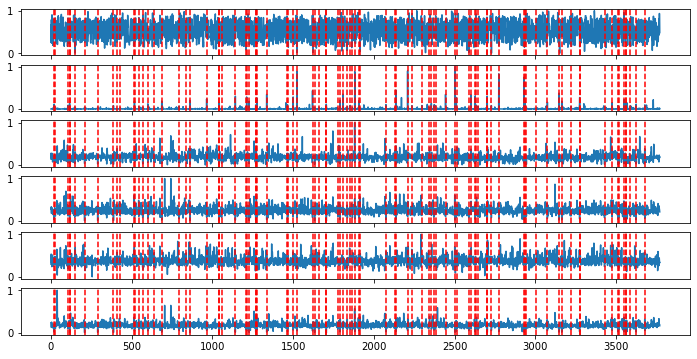

In [15]:
fig, axes = plt.subplots(6, 1, sharex=True, figsize=(12, 6))
axes[0].plot(X[:, 0])
axes[1].plot(X[:, 1])
axes[2].plot(X[:, 2])
axes[3].plot(X[:, 3])
axes[4].plot(X[:, 4])
axes[5].plot(X[:, 5])
for i in range(len(y)):
    if y[i] == 1:
        axes[0].axvline(i, linestyle='dashed', color='red')
        axes[1].axvline(i, linestyle='dashed', color='red')
        axes[2].axvline(i, linestyle='dashed', color='red')
        axes[3].axvline(i, linestyle='dashed', color='red')
        axes[4].axvline(i, linestyle='dashed', color='red')
        axes[5].axvline(i, linestyle='dashed', color='red')
plt.show()

## SDEM

In [16]:
def calc_scores_sdem(X, r, k, alpha=1.0, seed=0):
    np.random.seed(seed)
    rho_const = np.repeat([r], X.shape[0])
    sdem = SDEM(rho_const, alpha, n_components=k)

    sdem.fit(X[:10, :])

    for t in tqdm.tqdm(range(X.shape[0])):
        sdem.update(X[t, :])

    pi_est = np.array(sdem.pi_list)
    mu_est = np.array(sdem.means_list)
    sigma_est = np.array(sdem.covariances_list)
    
    anom_scores = [np.nan] * 1000

    n_cluster = pi_est.shape[1]
    for t in range(1000, pi_est.shape[0]):
        p = np.zeros(n_cluster)
        for i in range(n_cluster):
            p_i = pi_est[t-1, i] * multivariate_normal(mu_est[t-1, i, :], sigma_est[t-1, i, :, :]).pdf(X[t, :])
            p[i] = p_i
        p_tot = np.sum(p)
        if p_tot >= 1e-16:
            anom_scores.append(-np.log(p_tot))
        else:
            anom_scores.append(-np.log(-1.0/np.finfo(np.float).min))
    anom_scores = np.array(anom_scores)
    
    return anom_scores

In [17]:
r_list = [0.01, 0.03, 0.05, 0.1]
k_list = [1, 2, 3]

auc_tr_sdem = np.zeros((len(r_list), len(k_list)))
auc_te_sdem = np.zeros((len(r_list), len(k_list)))

for i, r in enumerate(r_list):
    for j, k in enumerate(k_list):
        seed = i*len(r_list) + j
        anom_scores = calc_scores_sdem(X, r, k, alpha=1.0, seed=seed)
        
        fpr_tr, tpr_tr, thresholds_tr = roc_curve(y[1000:2000], anom_scores[1000:2000], pos_label=1)
        auc_tr_sdem[i, j] = auc(fpr_tr, tpr_tr)
        
        fpr_te, tpr_te, thresholds_te = roc_curve(y[2000:], anom_scores[2000:], pos_label=1)
        auc_te_sdem[i, j] = auc(fpr_te, tpr_te)

100%|██████████| 3772/3772 [00:01<00:00, 2785.42it/s]


ValueError: the input matrix must be positive semidefinite

In [ ]:
np.unravel_index(np.argmax(auc_tr_sdem), auc_tr_sdem.shape)

In [19]:
auc_tr_sdem[0, 1]

0.9669377463688341

In [20]:
auc_te_sdem[0, 1]

0.9468070465180292

## IEM

In [18]:
def calc_scores_iem(X, k, alpha=1.0, seed=0):
    np.random.seed(seed)
    rhos = 1.0 / np.arange(1, X.shape[0]+1)
    sdem = SDEM(rhos, alpha, n_components=k)

    sdem.fit(X[:10, :])
    #sdem.weights_ = np.repeat([1/k], k)
    #sdem.means_ = np.hstack([ 
    #                    np.random.uniform(np.min(X[:2000, col]), np.max(X[:2000, col]), k).reshape(-1, 1)
    #                    for col in range(X.shape[1])
    #                ])
    #sdem.covariances_ = np.stack([np.diag((X[:2000, :].max(axis=0) - X[:2000, :].min(axis=0))/10) for _ in k_list])

    for t in tqdm.tqdm(range(X.shape[0])):
        sdem.update(X[t, :])

    pi_est = np.array(sdem.pi_list)
    mu_est = np.array(sdem.means_list)
    sigma_est = np.array(sdem.covariances_list)
    
    anom_scores = [np.nan] * 1000

    n_cluster = pi_est.shape[1]
    for t in range(1000, pi_est.shape[0]):
        p = np.zeros(n_cluster)
        for i in range(n_cluster):
            p_i = pi_est[t-1, i] * multivariate_normal(mu_est[t-1, i, :], sigma_est[t-1, i, :, :]).pdf(X[t, :])
            p[i] = p_i
        p_tot = np.sum(p)
        if p_tot >= 1e-16:
            anom_scores.append(-np.log(p_tot))
        else:
            anom_scores.append(-np.log(-1.0/np.finfo(np.float).min))
    anom_scores = np.array(anom_scores)
    
    return anom_scores

In [19]:
k_list = [1, 2, 3]

auc_tr_iem = np.zeros(len(k_list))
auc_te_iem = np.zeros(len(k_list))

for i, k in enumerate(k_list):
    seed = i
    anom_scores = calc_scores_iem(X, k, alpha=1.0, seed=seed)

    fpr_tr, tpr_tr, thresholds_tr = roc_curve(y[1000:2000], anom_scores[1000:2000], pos_label=1)
    auc_tr_iem[i] = auc(fpr_tr, tpr_tr)

    fpr_te, tpr_te, thresholds_te = roc_curve(y[2000:], anom_scores[2000:], pos_label=1)
    auc_te_iem[i] = auc(fpr_te, tpr_te)

100%|██████████| 3772/3772 [00:01<00:00, 2728.81it/s]


In [20]:
auc_tr_iem[np.argmax(auc_tr_iem)]

0.963493021769239

In [21]:
auc_te_iem[np.argmax(auc_tr_iem)]

0.9350605560143133

## sEM

In [22]:
def calc_scores_sem(X, theta0, r, k, seed=0):
    np.random.seed(seed)
    
    rho_const = np.repeat([r], X.shape[0])
    pi_est, mu_est, sigma_est = sem(X, theta0, rho_const)
    
    anom_scores = [np.nan]
    for t in range(1, pi_est.shape[0]):
        p = np.zeros(k)
        for i in range(k):
            p_i = pi_est[t-1, i] * multivariate_normal(mu_est[t-1, i, :], sigma_est[t-1, i, :, :], allow_singular=True).pdf(X[t, :])
            p[i] = p_i
        p_tot = np.sum(p)
        if p_tot >= 1e-16:
            anom_scores.append(-np.log(p_tot))
        else:
            anom_scores.append(-np.log(-1.0/np.finfo(np.float).min))
                        
    return anom_scores

In [23]:
k_list = [1, 2, 3]
r_list = [0.0001, 0.001, 0.01]

auc_tr_sem = np.zeros((len(r_list), len(k_list)))
auc_te_sem = np.zeros((len(r_list), len(k_list)))

for i, r in enumerate(r_list):
    for j, k in enumerate(k_list):
        print('r =', r, ', k =', k)
        seed = i*len(k_list) + j
        np.random.seed(seed)
        
        pi0 = np.array([1/k] * k).reshape(-1, 1)
        mu0 = np.hstack([ 
                  np.random.uniform(np.min(X[:2000, col]), np.max(X[:2000, col]), k).reshape(-1, 1)
                  for col in range(X.shape[1])
              ])
        sigma0 = np.stack([np.diag( (X[:2000, :].max(axis=0) - X[:2000, :].min(axis=0)) /10) for _ in range(k)])
        theta0 = Theta(pi0, mu0, sigma0)
            
        anom_scores = calc_scores_sem(X, theta0, r, k, seed=seed)

        fpr_tr, tpr_tr, thresholds_tr = roc_curve(y[1000:2000], anom_scores[1000:2000], pos_label=1)
        auc_tr_sem[i, j] = auc(fpr_tr, tpr_tr)

        fpr_te, tpr_te, thresholds_te = roc_curve(y[2000:], anom_scores[2000:], pos_label=1)
        auc_te_sem[i, j] = auc(fpr_te, tpr_te)

  0%|          | 0/3772 [00:00<?, ?it/s]/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
 14%|█▎        | 515/3772 [00:00<00:01, 2636.56it/s]

r = 0.0001 , k = 1


  5%|▌         | 192/3772 [00:00<00:01, 1915.40it/s]

r = 0.0001 , k = 2


  3%|▎         | 127/3772 [00:00<00:02, 1269.34it/s]

r = 0.0001 , k = 3


 16%|█▌        | 596/3772 [00:00<00:01, 2994.10it/s]

r = 0.001 , k = 1


  5%|▍         | 185/3772 [00:00<00:01, 1843.73it/s]

r = 0.001 , k = 2


  3%|▎         | 127/3772 [00:00<00:02, 1266.61it/s]

r = 0.001 , k = 3


 16%|█▌        | 593/3772 [00:00<00:01, 2943.52it/s]

r = 0.01 , k = 1


 10%|▉         | 366/3772 [00:00<00:01, 1816.98it/s]

r = 0.01 , k = 2


  3%|▎         | 131/3772 [00:00<00:02, 1303.26it/s]

r = 0.01 , k = 3


100%|██████████| 3772/3772 [00:02<00:00, 1276.17it/s]


In [24]:
np.unravel_index(np.argmax(auc_tr_sem), auc_tr_sem.shape)

(1, 0)

In [25]:
auc_tr_sem[1, 0]

0.979349408714798

In [26]:
auc_te_sem[1, 0]

0.968421414808698

## SRA

In [27]:
def calc_scores_sra(X, theta0, k, gamma, ratio, M, seed=0):
    np.random.seed(seed)
    
    rho = ratio * np.exp(-gamma**2/M**2) / (2.0*gamma)
    rho_const = np.repeat(rho, X.shape[0])
    pi_est, mu_est, sigma_est = sra(X, theta0, rho_const, gamma)
    
    anom_scores = []
    for t in range(pi_est.shape[0]):
        p = np.zeros(k)
        for i in range(k):
            p_i = pi_est[t-1, i] * multivariate_normal(mu_est[t-1, i, :], sigma_est[t-1, i, :, :], allow_singular=True).pdf(X[t, :])
            p[i] = p_i
        p_tot = np.sum(p)
        if p_tot >= 1e-16:
            anom_scores.append(-np.log(p_tot))
        else:
            anom_scores.append(-np.log(-1.0/np.finfo(np.float).min))
                        
    return anom_scores

In [28]:
n_trial = 5
k_list = [1, 2, 3]
gamma_list = [5, 10, 15]
ratio_list = [0.1, 0.5, 1.0]
M_list = [1.0, 5.0, 10.0]

In [29]:
auc_sra_tot = np.zeros((n_trial, len(k_list), len(gamma_list), len(ratio_list), len(M_list)))
auc_sra_tr = np.zeros((n_trial, len(k_list), len(gamma_list), len(ratio_list), len(M_list)))
auc_sra_te = np.zeros((n_trial, len(k_list), len(gamma_list), len(ratio_list), len(M_list)))

for n in range(n_trial):
    for i, k in enumerate(k_list):
        pi0 = np.array([1/k] * k).reshape(-1, 1)
        mu0 = np.hstack([ 
                  np.random.uniform(np.min(X[:2000, col]), np.max(X[:2000, col]), k).reshape(-1, 1)
                  for col in range(X.shape[1])
              ])
        sigma0 = np.stack([np.diag((X[:2000, :].max(axis=0) - X[:2000, :].min(axis=0))/10) for _ in range(k)])
        theta0 = Theta(pi0, mu0, sigma0)
        for j, gamma in enumerate(gamma_list):
            for l, ratio in enumerate(ratio_list):
                for m, M in enumerate(M_list):
                    scores = calc_scores_sra(X, theta0, k, gamma, ratio, M)
                    fpr, tpr, thresholds = roc_curve(y, scores, pos_label=1)
                    auc_sra_tot[n, i, j, l, m] = auc(fpr, tpr)
                    
                    fpr_tr, tpr_tr, thresholds_tr = roc_curve(y[1000:2000], scores[1000:2000], pos_label=1)
                    auc_sra_tr[n, i, j, l, m] = auc(fpr_tr, tpr_tr)
                    
                    fpr_te, tpr_te, thresholds_te = roc_curve(y[2000:], scores[2000:], pos_label=1)
                    auc_sra_te[n, i, j, l, m] = auc(fpr_te, tpr_te)
                    print('gamma=', gamma, ', ratio=', ratio, ', M=', M, ':', auc_sra_te[n, i, j, l, m])


  0%|          | 0/3772 [00:00<?, ?it/s]/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
  9%|▉         | 347/3772 [00:00<00:00, 3463.77it/s]

gamma= 5 , ratio= 0.1 , M= 1.0 : 0.9405243600330306


 16%|█▌        | 591/3772 [00:00<00:01, 2981.60it/s]

gamma= 5 , ratio= 0.1 , M= 5.0 : 0.9499311863473713


 17%|█▋        | 653/3772 [00:00<00:00, 3237.69it/s]

gamma= 5 , ratio= 0.1 , M= 10.0 : 0.9318676025323425


 15%|█▌        | 570/3772 [00:00<00:01, 2851.77it/s]

gamma= 5 , ratio= 0.5 , M= 1.0 : 0.9405243600330306


 15%|█▍        | 554/3772 [00:00<00:01, 2751.57it/s]

gamma= 5 , ratio= 0.5 , M= 5.0 : 0.9361134048995321


 16%|█▌        | 585/3772 [00:00<00:01, 2944.56it/s]

gamma= 5 , ratio= 0.5 , M= 10.0 : 0.9454720616570327


  7%|▋         | 261/3772 [00:00<00:01, 2609.22it/s]

gamma= 5 , ratio= 1.0 , M= 1.0 : 0.9405243600330306


 16%|█▌        | 586/3772 [00:00<00:01, 2933.87it/s]

gamma= 5 , ratio= 1.0 , M= 5.0 : 0.9453757225433526


  8%|▊         | 295/3772 [00:00<00:01, 2944.64it/s]

gamma= 5 , ratio= 1.0 , M= 10.0 : 0.9725708780622075


  8%|▊         | 290/3772 [00:00<00:01, 2893.69it/s]

gamma= 10 , ratio= 0.1 , M= 1.0 : 0.9405243600330306


  8%|▊         | 295/3772 [00:00<00:01, 2943.12it/s]

gamma= 10 , ratio= 0.1 , M= 5.0 : 0.9589388934764657


  8%|▊         | 296/3772 [00:00<00:01, 2951.53it/s]

gamma= 10 , ratio= 0.1 , M= 10.0 : 0.9287985136251032


 16%|█▌        | 592/3772 [00:00<00:01, 2937.28it/s]

gamma= 10 , ratio= 0.5 , M= 1.0 : 0.9405243600330306


 15%|█▍        | 561/3772 [00:00<00:01, 2842.56it/s]

gamma= 10 , ratio= 0.5 , M= 5.0 : 0.9825901458849435


 14%|█▎        | 517/3772 [00:00<00:01, 2603.13it/s]

gamma= 10 , ratio= 0.5 , M= 10.0 : 0.9322254335260116


 16%|█▌        | 586/3772 [00:00<00:01, 2928.96it/s]

gamma= 10 , ratio= 1.0 , M= 1.0 : 0.9405243600330306


  8%|▊         | 294/3772 [00:00<00:01, 2931.16it/s]

gamma= 10 , ratio= 1.0 , M= 5.0 : 0.9701348747591523


 14%|█▍        | 541/3772 [00:00<00:01, 2708.85it/s]

gamma= 10 , ratio= 1.0 , M= 10.0 : 0.9361134048995321


 15%|█▌        | 567/3772 [00:00<00:01, 2822.22it/s]

gamma= 15 , ratio= 0.1 , M= 1.0 : 0.9405243600330306


 15%|█▌        | 579/3772 [00:00<00:01, 2913.47it/s]

gamma= 15 , ratio= 0.1 , M= 5.0 : 0.9408064960088082


 16%|█▌        | 597/3772 [00:00<00:01, 2995.98it/s]

gamma= 15 , ratio= 0.1 , M= 10.0 : 0.9826451968070465


 15%|█▍        | 561/3772 [00:00<00:01, 2802.72it/s]

gamma= 15 , ratio= 0.5 , M= 1.0 : 0.9405243600330306


  7%|▋         | 282/3772 [00:00<00:01, 2813.87it/s]

gamma= 15 , ratio= 0.5 , M= 5.0 : 0.9413845306908891


  8%|▊         | 289/3772 [00:00<00:01, 2879.87it/s]

gamma= 15 , ratio= 0.5 , M= 10.0 : 0.9292526837324526


 16%|█▌        | 591/3772 [00:00<00:01, 2946.73it/s]

gamma= 15 , ratio= 1.0 , M= 1.0 : 0.9405243600330306


 16%|█▌        | 586/3772 [00:00<00:01, 2904.65it/s]

gamma= 15 , ratio= 1.0 , M= 5.0 : 0.9419763281034957


 10%|█         | 389/3772 [00:00<00:01, 1937.05it/s]

gamma= 15 , ratio= 1.0 , M= 10.0 : 0.9292664464629782


  5%|▍         | 188/3772 [00:00<00:01, 1877.43it/s]

gamma= 5 , ratio= 0.1 , M= 1.0 : 0.9404624277456648


  9%|▉         | 352/3772 [00:00<00:01, 1752.76it/s]

gamma= 5 , ratio= 0.1 , M= 5.0 : 0.9399669694467382


 10%|█         | 394/3772 [00:00<00:01, 1959.69it/s]

gamma= 5 , ratio= 0.1 , M= 10.0 : 0.9452656206991468


  5%|▍         | 175/3772 [00:00<00:02, 1743.41it/s]

gamma= 5 , ratio= 0.5 , M= 1.0 : 0.9404624277456648


 10%|▉         | 362/3772 [00:00<00:01, 1813.26it/s]

gamma= 5 , ratio= 0.5 , M= 5.0 : 0.942485549132948


  5%|▌         | 190/3772 [00:00<00:01, 1899.71it/s]

gamma= 5 , ratio= 0.5 , M= 10.0 : 0.9354734379300852


  4%|▍         | 159/3772 [00:00<00:02, 1585.39it/s]

gamma= 5 , ratio= 1.0 , M= 1.0 : 0.9404624277456648


  9%|▉         | 351/3772 [00:00<00:01, 1752.19it/s]

gamma= 5 , ratio= 1.0 , M= 5.0 : 0.9341590971648775


  5%|▍         | 182/3772 [00:00<00:01, 1813.88it/s]

gamma= 5 , ratio= 1.0 , M= 10.0 : 0.9725708780622075


  5%|▍         | 188/3772 [00:00<00:01, 1874.79it/s]

gamma= 10 , ratio= 0.1 , M= 1.0 : 0.9404624277456648


  4%|▍         | 156/3772 [00:00<00:02, 1552.45it/s]

gamma= 10 , ratio= 0.1 , M= 5.0 : 0.9769474263693917


  5%|▍         | 177/3772 [00:00<00:02, 1769.03it/s]

gamma= 10 , ratio= 0.1 , M= 10.0 : 0.931055601431324


  9%|▉         | 357/3772 [00:00<00:01, 1787.34it/s]

gamma= 10 , ratio= 0.5 , M= 1.0 : 0.9404624277456648


  4%|▍         | 167/3772 [00:00<00:02, 1667.18it/s]

gamma= 10 , ratio= 0.5 , M= 5.0 : 0.9659922928709056


  4%|▍         | 165/3772 [00:00<00:02, 1641.29it/s]

gamma= 10 , ratio= 0.5 , M= 10.0 : 0.9460088081475364


  4%|▍         | 167/3772 [00:00<00:02, 1667.00it/s]

gamma= 10 , ratio= 1.0 , M= 1.0 : 0.9404624277456648


  5%|▍         | 174/3772 [00:00<00:02, 1732.93it/s]

gamma= 10 , ratio= 1.0 , M= 5.0 : 0.9460432149738508


  4%|▍         | 169/3772 [00:00<00:02, 1689.66it/s]

gamma= 10 , ratio= 1.0 , M= 10.0 : 0.942485549132948


  5%|▍         | 181/3772 [00:00<00:01, 1808.54it/s]

gamma= 15 , ratio= 0.1 , M= 1.0 : 0.9404624277456648


  5%|▍         | 188/3772 [00:00<00:01, 1875.14it/s]

gamma= 15 , ratio= 0.1 , M= 5.0 : 0.9404624277456648


  9%|▉         | 341/3772 [00:00<00:02, 1701.62it/s]

gamma= 15 , ratio= 0.1 , M= 10.0 : 0.9677470410129371


  5%|▍         | 179/3772 [00:00<00:02, 1784.31it/s]

gamma= 15 , ratio= 0.5 , M= 1.0 : 0.9404624277456648


 10%|▉         | 368/3772 [00:00<00:01, 1819.00it/s]

gamma= 15 , ratio= 0.5 , M= 5.0 : 0.9410404624277456


  5%|▍         | 182/3772 [00:00<00:01, 1811.58it/s]

gamma= 15 , ratio= 0.5 , M= 10.0 : 0.9304362785576659


  5%|▍         | 181/3772 [00:00<00:01, 1809.00it/s]

gamma= 15 , ratio= 1.0 , M= 1.0 : 0.9404624277456648


  5%|▍         | 171/3772 [00:00<00:02, 1707.04it/s]

gamma= 15 , ratio= 1.0 , M= 5.0 : 0.9399325626204239


  3%|▎         | 128/3772 [00:00<00:02, 1270.81it/s]

gamma= 15 , ratio= 1.0 , M= 10.0 : 0.9396091384530691


  3%|▎         | 125/3772 [00:00<00:02, 1246.19it/s]

gamma= 5 , ratio= 0.1 , M= 1.0 : 0.9431323974676576


  3%|▎         | 114/3772 [00:00<00:03, 1131.44it/s]

gamma= 5 , ratio= 0.1 , M= 5.0 : 0.9427470410129369


  4%|▎         | 138/3772 [00:00<00:02, 1374.31it/s]

gamma= 5 , ratio= 0.1 , M= 10.0 : 0.9437517203413157


  3%|▎         | 129/3772 [00:00<00:02, 1289.84it/s]

gamma= 5 , ratio= 0.5 , M= 1.0 : 0.9431323974676576


  6%|▋         | 236/3772 [00:00<00:03, 1172.26it/s]

gamma= 5 , ratio= 0.5 , M= 5.0 : 0.9423892100192678


  3%|▎         | 131/3772 [00:00<00:02, 1301.85it/s]

gamma= 5 , ratio= 0.5 , M= 10.0 : 0.9454720616570327


  6%|▌         | 235/3772 [00:00<00:03, 1177.99it/s]

gamma= 5 , ratio= 1.0 , M= 1.0 : 0.9431323974676576


  4%|▎         | 134/3772 [00:00<00:02, 1334.01it/s]

gamma= 5 , ratio= 1.0 , M= 5.0 : 0.9453757225433526


  3%|▎         | 125/3772 [00:00<00:02, 1249.14it/s]

gamma= 5 , ratio= 1.0 , M= 10.0 : 0.9725708780622075


  7%|▋         | 249/3772 [00:00<00:02, 1251.64it/s]

gamma= 10 , ratio= 0.1 , M= 1.0 : 0.9431323974676575


  3%|▎         | 131/3772 [00:00<00:02, 1308.17it/s]

gamma= 10 , ratio= 0.1 , M= 5.0 : 0.9810624827965868


  4%|▎         | 134/3772 [00:00<00:02, 1336.14it/s]

gamma= 10 , ratio= 0.1 , M= 10.0 : 0.9369804569226534


  7%|▋         | 256/3772 [00:00<00:02, 1277.39it/s]

gamma= 10 , ratio= 0.5 , M= 1.0 : 0.9431323974676575


  3%|▎         | 127/3772 [00:00<00:02, 1268.96it/s]

gamma= 10 , ratio= 0.5 , M= 5.0 : 0.9720203688411782


  3%|▎         | 118/3772 [00:00<00:03, 1178.53it/s]

gamma= 10 , ratio= 0.5 , M= 10.0 : 0.943999449490779


  4%|▎         | 137/3772 [00:00<00:02, 1361.48it/s]

gamma= 10 , ratio= 1.0 , M= 1.0 : 0.9431323974676575


  3%|▎         | 124/3772 [00:00<00:02, 1237.18it/s]

gamma= 10 , ratio= 1.0 , M= 5.0 : 0.935390861546931


  3%|▎         | 131/3772 [00:00<00:02, 1307.01it/s]

gamma= 10 , ratio= 1.0 , M= 10.0 : 0.9423892100192678


  3%|▎         | 107/3772 [00:00<00:03, 1067.14it/s]

gamma= 15 , ratio= 0.1 , M= 1.0 : 0.9431323974676575


  7%|▋         | 256/3772 [00:00<00:02, 1284.85it/s]

gamma= 15 , ratio= 0.1 , M= 5.0 : 0.9434282961739608


  3%|▎         | 112/3772 [00:00<00:03, 1115.04it/s]

gamma= 15 , ratio= 0.1 , M= 10.0 : 0.975419763281035


  3%|▎         | 130/3772 [00:00<00:02, 1298.91it/s]

gamma= 15 , ratio= 0.5 , M= 1.0 : 0.9431323974676575


  3%|▎         | 129/3772 [00:00<00:02, 1286.22it/s]

gamma= 15 , ratio= 0.5 , M= 5.0 : 0.9448940269749518


  4%|▎         | 133/3772 [00:00<00:02, 1320.62it/s]

gamma= 15 , ratio= 0.5 , M= 10.0 : 0.9366088631984586


  3%|▎         | 107/3772 [00:00<00:03, 1064.66it/s]

gamma= 15 , ratio= 1.0 , M= 1.0 : 0.9431323974676575


  6%|▌         | 235/3772 [00:00<00:02, 1188.07it/s]

gamma= 15 , ratio= 1.0 , M= 5.0 : 0.9464010459675201


 17%|█▋        | 646/3772 [00:00<00:00, 3233.12it/s]

gamma= 15 , ratio= 1.0 , M= 10.0 : 0.9424167354803192


  9%|▊         | 322/3772 [00:00<00:01, 3212.55it/s]

gamma= 5 , ratio= 0.1 , M= 1.0 : 0.9405243600330306


  7%|▋         | 276/3772 [00:00<00:01, 2752.27it/s]

gamma= 5 , ratio= 0.1 , M= 5.0 : 0.9499311863473713


 16%|█▌        | 605/3772 [00:00<00:01, 3001.94it/s]

gamma= 5 , ratio= 0.1 , M= 10.0 : 0.9318676025323425


 15%|█▍        | 563/3772 [00:00<00:01, 2808.02it/s]

gamma= 5 , ratio= 0.5 , M= 1.0 : 0.9405243600330306


 15%|█▌        | 582/3772 [00:00<00:01, 2912.39it/s]

gamma= 5 , ratio= 0.5 , M= 5.0 : 0.9361134048995321


  9%|▉         | 333/3772 [00:00<00:01, 3325.14it/s]

gamma= 5 , ratio= 0.5 , M= 10.0 : 0.9454720616570327


 15%|█▌        | 583/3772 [00:00<00:01, 2914.09it/s]

gamma= 5 , ratio= 1.0 , M= 1.0 : 0.9405243600330306


  7%|▋         | 277/3772 [00:00<00:01, 2765.96it/s]

gamma= 5 , ratio= 1.0 , M= 5.0 : 0.9453757225433526


  7%|▋         | 255/3772 [00:00<00:01, 2540.29it/s]

gamma= 5 , ratio= 1.0 , M= 10.0 : 0.9725708780622075


  7%|▋         | 280/3772 [00:00<00:01, 2791.72it/s]

gamma= 10 , ratio= 0.1 , M= 1.0 : 0.9405243600330306


 14%|█▍        | 535/3772 [00:00<00:01, 2686.67it/s]

gamma= 10 , ratio= 0.1 , M= 5.0 : 0.9589388934764657


  7%|▋         | 257/3772 [00:00<00:01, 2563.01it/s]

gamma= 10 , ratio= 0.1 , M= 10.0 : 0.9287985136251032


  7%|▋         | 264/3772 [00:00<00:01, 2630.92it/s]

gamma= 10 , ratio= 0.5 , M= 1.0 : 0.9405243600330306


 13%|█▎        | 491/3772 [00:00<00:01, 2471.34it/s]

gamma= 10 , ratio= 0.5 , M= 5.0 : 0.9825901458849435


 13%|█▎        | 482/3772 [00:00<00:01, 2434.54it/s]

gamma= 10 , ratio= 0.5 , M= 10.0 : 0.9322254335260116


  6%|▋         | 240/3772 [00:00<00:01, 2394.66it/s]

gamma= 10 , ratio= 1.0 , M= 1.0 : 0.9405243600330306


 14%|█▍        | 534/3772 [00:00<00:01, 2684.87it/s]

gamma= 10 , ratio= 1.0 , M= 5.0 : 0.9701348747591523


  7%|▋         | 265/3772 [00:00<00:01, 2641.09it/s]

gamma= 10 , ratio= 1.0 , M= 10.0 : 0.9361134048995321


  7%|▋         | 260/3772 [00:00<00:01, 2592.82it/s]

gamma= 15 , ratio= 0.1 , M= 1.0 : 0.9405243600330306


 14%|█▍        | 533/3772 [00:00<00:01, 2650.92it/s]

gamma= 15 , ratio= 0.1 , M= 5.0 : 0.9408064960088082


 12%|█▏        | 435/3772 [00:00<00:01, 2247.60it/s]

gamma= 15 , ratio= 0.1 , M= 10.0 : 0.9826451968070465


  6%|▌         | 228/3772 [00:00<00:01, 2271.43it/s]

gamma= 15 , ratio= 0.5 , M= 1.0 : 0.9405243600330306


  5%|▌         | 206/3772 [00:00<00:01, 2057.78it/s]

gamma= 15 , ratio= 0.5 , M= 5.0 : 0.9413845306908891


 14%|█▍        | 528/3772 [00:00<00:01, 2628.62it/s]

gamma= 15 , ratio= 0.5 , M= 10.0 : 0.9292526837324526


  6%|▌         | 225/3772 [00:00<00:01, 2247.97it/s]

gamma= 15 , ratio= 1.0 , M= 1.0 : 0.9405243600330306


 12%|█▏        | 468/3772 [00:00<00:01, 2410.47it/s]

gamma= 15 , ratio= 1.0 , M= 5.0 : 0.9419763281034957


  4%|▍         | 169/3772 [00:00<00:02, 1687.57it/s]

gamma= 15 , ratio= 1.0 , M= 10.0 : 0.9292664464629782


  4%|▍         | 158/3772 [00:00<00:02, 1572.66it/s]

gamma= 5 , ratio= 0.1 , M= 1.0 : 0.9404624277456648


  8%|▊         | 315/3772 [00:00<00:02, 1572.91it/s]

gamma= 5 , ratio= 0.1 , M= 5.0 : 0.9399669694467382


  9%|▊         | 321/3772 [00:00<00:02, 1578.82it/s]

gamma= 5 , ratio= 0.1 , M= 10.0 : 0.9452656206991468


  9%|▊         | 324/3772 [00:00<00:02, 1643.21it/s]

gamma= 5 , ratio= 0.5 , M= 1.0 : 0.9404624277456648


  4%|▍         | 157/3772 [00:00<00:02, 1561.52it/s]

gamma= 5 , ratio= 0.5 , M= 5.0 : 0.942485549132948


  4%|▍         | 152/3772 [00:00<00:02, 1516.50it/s]

gamma= 5 , ratio= 0.5 , M= 10.0 : 0.9354734379300852


  8%|▊         | 307/3772 [00:00<00:02, 1535.42it/s]

gamma= 5 , ratio= 1.0 , M= 1.0 : 0.9404624277456648


  4%|▍         | 153/3772 [00:00<00:02, 1526.81it/s]

gamma= 5 , ratio= 1.0 , M= 5.0 : 0.9341590971648775


  3%|▎         | 128/3772 [00:00<00:02, 1272.91it/s]

gamma= 5 , ratio= 1.0 , M= 10.0 : 0.9725708780622075


  4%|▎         | 137/3772 [00:00<00:02, 1368.33it/s]

gamma= 10 , ratio= 0.1 , M= 1.0 : 0.9404624277456648


  7%|▋         | 280/3772 [00:00<00:02, 1419.03it/s]

gamma= 10 , ratio= 0.1 , M= 5.0 : 0.9769474263693917


  3%|▎         | 129/3772 [00:00<00:02, 1287.12it/s]

gamma= 10 , ratio= 0.1 , M= 10.0 : 0.931055601431324


  8%|▊         | 295/3772 [00:00<00:02, 1490.36it/s]

gamma= 10 , ratio= 0.5 , M= 1.0 : 0.9404624277456648


  4%|▍         | 152/3772 [00:00<00:02, 1513.20it/s]

gamma= 10 , ratio= 0.5 , M= 5.0 : 0.9659922928709056


  8%|▊         | 300/3772 [00:00<00:02, 1501.81it/s]

gamma= 10 , ratio= 0.5 , M= 10.0 : 0.9460088081475364


  4%|▍         | 148/3772 [00:00<00:02, 1479.16it/s]

gamma= 10 , ratio= 1.0 , M= 1.0 : 0.9404624277456648


  4%|▍         | 153/3772 [00:00<00:02, 1521.85it/s]

gamma= 10 , ratio= 1.0 , M= 5.0 : 0.9460432149738508


  7%|▋         | 280/3772 [00:00<00:02, 1380.66it/s]

gamma= 10 , ratio= 1.0 , M= 10.0 : 0.942485549132948


  8%|▊         | 283/3772 [00:00<00:02, 1413.43it/s]

gamma= 15 , ratio= 0.1 , M= 1.0 : 0.9404624277456648


  8%|▊         | 303/3772 [00:00<00:02, 1497.24it/s]

gamma= 15 , ratio= 0.1 , M= 5.0 : 0.9404624277456648


  4%|▍         | 148/3772 [00:00<00:02, 1477.65it/s]

gamma= 15 , ratio= 0.1 , M= 10.0 : 0.9677470410129371


  8%|▊         | 297/3772 [00:00<00:02, 1506.25it/s]

gamma= 15 , ratio= 0.5 , M= 1.0 : 0.9404624277456648


  8%|▊         | 318/3772 [00:00<00:02, 1583.75it/s]

gamma= 15 , ratio= 0.5 , M= 5.0 : 0.9410404624277456


  4%|▍         | 152/3772 [00:00<00:02, 1508.69it/s]

gamma= 15 , ratio= 0.5 , M= 10.0 : 0.9304362785576659


  4%|▍         | 154/3772 [00:00<00:02, 1538.28it/s]

gamma= 15 , ratio= 1.0 , M= 1.0 : 0.9404624277456648


  4%|▍         | 144/3772 [00:00<00:02, 1439.17it/s]

gamma= 15 , ratio= 1.0 , M= 5.0 : 0.9399325626204239


  3%|▎         | 101/3772 [00:00<00:03, 1003.30it/s]

gamma= 15 , ratio= 1.0 , M= 10.0 : 0.9396091384530691


  6%|▌         | 220/3772 [00:00<00:03, 1103.08it/s]

gamma= 5 , ratio= 0.1 , M= 1.0 : 0.9431323974676576


  3%|▎         | 111/3772 [00:00<00:03, 1102.92it/s]

gamma= 5 , ratio= 0.1 , M= 5.0 : 0.9427470410129369


  3%|▎         | 101/3772 [00:00<00:03, 1005.31it/s]

gamma= 5 , ratio= 0.1 , M= 10.0 : 0.9437517203413157


  3%|▎         | 105/3772 [00:00<00:03, 1040.19it/s]

gamma= 5 , ratio= 0.5 , M= 1.0 : 0.9431323974676576


  3%|▎         | 107/3772 [00:00<00:03, 1068.47it/s]

gamma= 5 , ratio= 0.5 , M= 5.0 : 0.9423892100192678


  3%|▎         | 106/3772 [00:00<00:03, 1047.88it/s]

gamma= 5 , ratio= 0.5 , M= 10.0 : 0.9454720616570327


  3%|▎         | 106/3772 [00:00<00:03, 1054.36it/s]

gamma= 5 , ratio= 1.0 , M= 1.0 : 0.9431323974676576


  3%|▎         | 102/3772 [00:00<00:03, 1019.24it/s]

gamma= 5 , ratio= 1.0 , M= 5.0 : 0.9453757225433526


  3%|▎         | 100/3772 [00:00<00:03, 995.16it/s]

gamma= 5 , ratio= 1.0 , M= 10.0 : 0.9725708780622075


  3%|▎         | 114/3772 [00:00<00:03, 1130.36it/s]

gamma= 10 , ratio= 0.1 , M= 1.0 : 0.9431323974676575


  3%|▎         | 115/3772 [00:00<00:03, 1147.67it/s]

gamma= 10 , ratio= 0.1 , M= 5.0 : 0.9810624827965868


  3%|▎         | 110/3772 [00:00<00:03, 1098.50it/s]

gamma= 10 , ratio= 0.1 , M= 10.0 : 0.9369804569226534


  3%|▎         | 113/3772 [00:00<00:03, 1121.72it/s]

gamma= 10 , ratio= 0.5 , M= 1.0 : 0.9431323974676575


  3%|▎         | 104/3772 [00:00<00:03, 1036.57it/s]

gamma= 10 , ratio= 0.5 , M= 5.0 : 0.9720203688411782


  3%|▎         | 107/3772 [00:00<00:03, 1062.08it/s]

gamma= 10 , ratio= 0.5 , M= 10.0 : 0.943999449490779


  3%|▎         | 106/3772 [00:00<00:03, 1055.01it/s]

gamma= 10 , ratio= 1.0 , M= 1.0 : 0.9431323974676575


  3%|▎         | 105/3772 [00:00<00:03, 1044.22it/s]

gamma= 10 , ratio= 1.0 , M= 5.0 : 0.935390861546931


  3%|▎         | 113/3772 [00:00<00:03, 1121.53it/s]

gamma= 10 , ratio= 1.0 , M= 10.0 : 0.9423892100192678


  3%|▎         | 107/3772 [00:00<00:03, 1063.65it/s]

gamma= 15 , ratio= 0.1 , M= 1.0 : 0.9431323974676575


  3%|▎         | 105/3772 [00:00<00:03, 1046.10it/s]

gamma= 15 , ratio= 0.1 , M= 5.0 : 0.9434282961739608


  3%|▎         | 113/3772 [00:00<00:03, 1119.74it/s]

gamma= 15 , ratio= 0.1 , M= 10.0 : 0.975419763281035


  3%|▎         | 111/3772 [00:00<00:03, 1102.84it/s]

gamma= 15 , ratio= 0.5 , M= 1.0 : 0.9431323974676575


  3%|▎         | 108/3772 [00:00<00:03, 1075.99it/s]

gamma= 15 , ratio= 0.5 , M= 5.0 : 0.9448940269749518


  3%|▎         | 108/3772 [00:00<00:03, 1072.71it/s]

gamma= 15 , ratio= 0.5 , M= 10.0 : 0.9366088631984586


  6%|▌         | 222/3772 [00:00<00:03, 1120.20it/s]

gamma= 15 , ratio= 1.0 , M= 1.0 : 0.9431323974676575


  3%|▎         | 109/3772 [00:00<00:03, 1087.76it/s]

gamma= 15 , ratio= 1.0 , M= 5.0 : 0.9464010459675201


  8%|▊         | 294/3772 [00:00<00:01, 2934.34it/s]

gamma= 15 , ratio= 1.0 , M= 10.0 : 0.9424167354803192


  8%|▊         | 285/3772 [00:00<00:01, 2847.61it/s]

gamma= 5 , ratio= 0.1 , M= 1.0 : 0.9405243600330306


  6%|▋         | 244/3772 [00:00<00:01, 2433.51it/s]

gamma= 5 , ratio= 0.1 , M= 5.0 : 0.9499311863473713


  7%|▋         | 278/3772 [00:00<00:01, 2771.27it/s]

gamma= 5 , ratio= 0.1 , M= 10.0 : 0.9318676025323425


 13%|█▎        | 487/3772 [00:00<00:01, 2401.69it/s]

gamma= 5 , ratio= 0.5 , M= 1.0 : 0.9405243600330306


  6%|▋         | 242/3772 [00:00<00:01, 2415.53it/s]

gamma= 5 , ratio= 0.5 , M= 5.0 : 0.9361134048995321


 14%|█▍        | 527/3772 [00:00<00:01, 2677.67it/s]

gamma= 5 , ratio= 0.5 , M= 10.0 : 0.9454720616570327


  6%|▌         | 232/3772 [00:00<00:01, 2317.99it/s]

gamma= 5 , ratio= 1.0 , M= 1.0 : 0.9405243600330306


  6%|▌         | 219/3772 [00:00<00:01, 2181.58it/s]

gamma= 5 , ratio= 1.0 , M= 5.0 : 0.9453757225433526


 13%|█▎        | 483/3772 [00:00<00:01, 2409.97it/s]

gamma= 5 , ratio= 1.0 , M= 10.0 : 0.9725708780622075


 13%|█▎        | 482/3772 [00:00<00:01, 2407.11it/s]

gamma= 10 , ratio= 0.1 , M= 1.0 : 0.9405243600330306


 12%|█▏        | 462/3772 [00:00<00:01, 2331.58it/s]

gamma= 10 , ratio= 0.1 , M= 5.0 : 0.9589388934764657


  6%|▋         | 238/3772 [00:00<00:01, 2372.10it/s]

gamma= 10 , ratio= 0.1 , M= 10.0 : 0.9287985136251032


 13%|█▎        | 490/3772 [00:00<00:01, 2448.64it/s]

gamma= 10 , ratio= 0.5 , M= 1.0 : 0.9405243600330306


 13%|█▎        | 486/3772 [00:00<00:01, 2442.79it/s]

gamma= 10 , ratio= 0.5 , M= 5.0 : 0.9825901458849435


 13%|█▎        | 482/3772 [00:00<00:01, 2423.96it/s]

gamma= 10 , ratio= 0.5 , M= 10.0 : 0.9322254335260116


 13%|█▎        | 477/3772 [00:00<00:01, 2384.37it/s]

gamma= 10 , ratio= 1.0 , M= 1.0 : 0.9405243600330306


  6%|▌         | 217/3772 [00:00<00:01, 2164.56it/s]

gamma= 10 , ratio= 1.0 , M= 5.0 : 0.9701348747591523


  6%|▋         | 242/3772 [00:00<00:01, 2409.64it/s]

gamma= 10 , ratio= 1.0 , M= 10.0 : 0.9361134048995321


  6%|▌         | 213/3772 [00:00<00:01, 2126.19it/s]

gamma= 15 , ratio= 0.1 , M= 1.0 : 0.9405243600330306


  6%|▌         | 227/3772 [00:00<00:01, 2263.32it/s]

gamma= 15 , ratio= 0.1 , M= 5.0 : 0.9408064960088082


 12%|█▏        | 451/3772 [00:00<00:01, 2270.80it/s]

gamma= 15 , ratio= 0.1 , M= 10.0 : 0.9826451968070465


  6%|▌         | 226/3772 [00:00<00:01, 2252.59it/s]

gamma= 15 , ratio= 0.5 , M= 1.0 : 0.9405243600330306


  6%|▌         | 228/3772 [00:00<00:01, 2271.48it/s]

gamma= 15 , ratio= 0.5 , M= 5.0 : 0.9413845306908891


  6%|▌         | 228/3772 [00:00<00:01, 2273.95it/s]

gamma= 15 , ratio= 0.5 , M= 10.0 : 0.9292526837324526


  6%|▋         | 243/3772 [00:00<00:01, 2422.92it/s]

gamma= 15 , ratio= 1.0 , M= 1.0 : 0.9405243600330306


  6%|▌         | 230/3772 [00:00<00:01, 2292.27it/s]

gamma= 15 , ratio= 1.0 , M= 5.0 : 0.9419763281034957


  4%|▍         | 163/3772 [00:00<00:02, 1626.54it/s]

gamma= 15 , ratio= 1.0 , M= 10.0 : 0.9292664464629782


  4%|▍         | 147/3772 [00:00<00:02, 1465.71it/s]

gamma= 5 , ratio= 0.1 , M= 1.0 : 0.9404624277456648


  4%|▍         | 142/3772 [00:00<00:02, 1413.36it/s]

gamma= 5 , ratio= 0.1 , M= 5.0 : 0.9399669694467382


  4%|▍         | 145/3772 [00:00<00:02, 1439.24it/s]

gamma= 5 , ratio= 0.1 , M= 10.0 : 0.9452656206991468


  4%|▎         | 138/3772 [00:00<00:02, 1369.28it/s]

gamma= 5 , ratio= 0.5 , M= 1.0 : 0.9404624277456648


  3%|▎         | 128/3772 [00:00<00:02, 1270.94it/s]

gamma= 5 , ratio= 0.5 , M= 5.0 : 0.942485549132948


  7%|▋         | 260/3772 [00:00<00:02, 1277.85it/s]

gamma= 5 , ratio= 0.5 , M= 10.0 : 0.9354734379300852


  3%|▎         | 129/3772 [00:00<00:02, 1285.57it/s]

gamma= 5 , ratio= 1.0 , M= 1.0 : 0.9404624277456648


  3%|▎         | 127/3772 [00:00<00:02, 1262.36it/s]

gamma= 5 , ratio= 1.0 , M= 5.0 : 0.9341590971648775


  3%|▎         | 124/3772 [00:00<00:02, 1236.86it/s]

gamma= 5 , ratio= 1.0 , M= 10.0 : 0.9725708780622075


  3%|▎         | 126/3772 [00:00<00:02, 1254.81it/s]

gamma= 10 , ratio= 0.1 , M= 1.0 : 0.9404624277456648


  4%|▎         | 139/3772 [00:00<00:02, 1381.03it/s]

gamma= 10 , ratio= 0.1 , M= 5.0 : 0.9769474263693917


  4%|▎         | 134/3772 [00:00<00:02, 1335.34it/s]

gamma= 10 , ratio= 0.1 , M= 10.0 : 0.931055601431324


  8%|▊         | 286/3772 [00:00<00:02, 1435.94it/s]

gamma= 10 , ratio= 0.5 , M= 1.0 : 0.9404624277456648


  3%|▎         | 129/3772 [00:00<00:02, 1286.42it/s]

gamma= 10 , ratio= 0.5 , M= 5.0 : 0.9659922928709056


  4%|▍         | 154/3772 [00:00<00:02, 1536.18it/s]

gamma= 10 , ratio= 0.5 , M= 10.0 : 0.9460088081475364


  4%|▍         | 151/3772 [00:00<00:02, 1502.46it/s]

gamma= 10 , ratio= 1.0 , M= 1.0 : 0.9404624277456648


  4%|▍         | 155/3772 [00:00<00:02, 1548.02it/s]

gamma= 10 , ratio= 1.0 , M= 5.0 : 0.9460432149738508


  4%|▍         | 152/3772 [00:00<00:02, 1512.24it/s]

gamma= 10 , ratio= 1.0 , M= 10.0 : 0.942485549132948


  4%|▎         | 140/3772 [00:00<00:02, 1396.19it/s]

gamma= 15 , ratio= 0.1 , M= 1.0 : 0.9404624277456648


  8%|▊         | 295/3772 [00:00<00:02, 1486.18it/s]

gamma= 15 , ratio= 0.1 , M= 5.0 : 0.9404624277456648


  8%|▊         | 310/3772 [00:00<00:02, 1542.54it/s]

gamma= 15 , ratio= 0.1 , M= 10.0 : 0.9677470410129371


  4%|▍         | 146/3772 [00:00<00:02, 1454.85it/s]

gamma= 15 , ratio= 0.5 , M= 1.0 : 0.9404624277456648


  4%|▍         | 148/3772 [00:00<00:02, 1474.82it/s]

gamma= 15 , ratio= 0.5 , M= 5.0 : 0.9410404624277456


  4%|▎         | 141/3772 [00:00<00:02, 1401.79it/s]

gamma= 15 , ratio= 0.5 , M= 10.0 : 0.9304362785576659


  8%|▊         | 292/3772 [00:00<00:02, 1464.37it/s]

gamma= 15 , ratio= 1.0 , M= 1.0 : 0.9404624277456648


  4%|▎         | 140/3772 [00:00<00:02, 1393.15it/s]

gamma= 15 , ratio= 1.0 , M= 5.0 : 0.9399325626204239


  3%|▎         | 110/3772 [00:00<00:03, 1092.62it/s]

gamma= 15 , ratio= 1.0 , M= 10.0 : 0.9396091384530691


  3%|▎         | 99/3772 [00:00<00:03, 987.40it/s]

gamma= 5 , ratio= 0.1 , M= 1.0 : 0.9431323974676576


  3%|▎         | 107/3772 [00:00<00:03, 1066.27it/s]

gamma= 5 , ratio= 0.1 , M= 5.0 : 0.9427470410129369


  2%|▏         | 92/3772 [00:00<00:04, 914.87it/s]

gamma= 5 , ratio= 0.1 , M= 10.0 : 0.9437517203413157


  3%|▎         | 106/3772 [00:00<00:03, 1054.43it/s]

gamma= 5 , ratio= 0.5 , M= 1.0 : 0.9431323974676576


  5%|▌         | 205/3772 [00:00<00:03, 1021.49it/s]

gamma= 5 , ratio= 0.5 , M= 5.0 : 0.9423892100192678


  3%|▎         | 110/3772 [00:00<00:03, 1099.10it/s]

gamma= 5 , ratio= 0.5 , M= 10.0 : 0.9454720616570327


  3%|▎         | 110/3772 [00:00<00:03, 1091.45it/s]

gamma= 5 , ratio= 1.0 , M= 1.0 : 0.9431323974676576


  3%|▎         | 106/3772 [00:00<00:03, 1056.59it/s]

gamma= 5 , ratio= 1.0 , M= 5.0 : 0.9453757225433526


  3%|▎         | 106/3772 [00:00<00:03, 1058.02it/s]

gamma= 5 , ratio= 1.0 , M= 10.0 : 0.9725708780622075


  3%|▎         | 108/3772 [00:00<00:03, 1071.82it/s]

gamma= 10 , ratio= 0.1 , M= 1.0 : 0.9431323974676575


  3%|▎         | 98/3772 [00:00<00:03, 977.55it/s]

gamma= 10 , ratio= 0.1 , M= 5.0 : 0.9810624827965868


  3%|▎         | 104/3772 [00:00<00:03, 1038.22it/s]

gamma= 10 , ratio= 0.1 , M= 10.0 : 0.9369804569226534


  3%|▎         | 105/3772 [00:00<00:03, 1043.58it/s]

gamma= 10 , ratio= 0.5 , M= 1.0 : 0.9431323974676575


  3%|▎         | 110/3772 [00:00<00:03, 1095.38it/s]

gamma= 10 , ratio= 0.5 , M= 5.0 : 0.9720203688411782


  3%|▎         | 102/3772 [00:00<00:03, 1014.66it/s]

gamma= 10 , ratio= 0.5 , M= 10.0 : 0.943999449490779


  3%|▎         | 97/3772 [00:00<00:03, 960.74it/s]

gamma= 10 , ratio= 1.0 , M= 1.0 : 0.9431323974676575


  2%|▏         | 93/3772 [00:00<00:03, 921.99it/s]

gamma= 10 , ratio= 1.0 , M= 5.0 : 0.935390861546931


  3%|▎         | 103/3772 [00:00<00:03, 1022.09it/s]

gamma= 10 , ratio= 1.0 , M= 10.0 : 0.9423892100192678


  3%|▎         | 102/3772 [00:00<00:03, 1016.26it/s]

gamma= 15 , ratio= 0.1 , M= 1.0 : 0.9431323974676575


  3%|▎         | 99/3772 [00:00<00:03, 984.03it/s]

gamma= 15 , ratio= 0.1 , M= 5.0 : 0.9434282961739608


  3%|▎         | 104/3772 [00:00<00:03, 1034.37it/s]

gamma= 15 , ratio= 0.1 , M= 10.0 : 0.975419763281035


  3%|▎         | 108/3772 [00:00<00:03, 1074.79it/s]

gamma= 15 , ratio= 0.5 , M= 1.0 : 0.9431323974676575


  3%|▎         | 105/3772 [00:00<00:03, 1046.22it/s]

gamma= 15 , ratio= 0.5 , M= 5.0 : 0.9448940269749518


  3%|▎         | 102/3772 [00:00<00:03, 1014.40it/s]

gamma= 15 , ratio= 0.5 , M= 10.0 : 0.9366088631984586


  3%|▎         | 99/3772 [00:00<00:03, 987.58it/s]

gamma= 15 , ratio= 1.0 , M= 1.0 : 0.9431323974676575


  6%|▌         | 209/3772 [00:00<00:03, 1042.40it/s]

gamma= 15 , ratio= 1.0 , M= 5.0 : 0.9464010459675201


  7%|▋         | 278/3772 [00:00<00:01, 2775.40it/s]

gamma= 15 , ratio= 1.0 , M= 10.0 : 0.9424167354803192


  7%|▋         | 268/3772 [00:00<00:01, 2668.90it/s]

gamma= 5 , ratio= 0.1 , M= 1.0 : 0.9405243600330306


  6%|▋         | 236/3772 [00:00<00:01, 2355.53it/s]

gamma= 5 , ratio= 0.1 , M= 5.0 : 0.9499311863473713


  6%|▋         | 241/3772 [00:00<00:01, 2402.44it/s]

gamma= 5 , ratio= 0.1 , M= 10.0 : 0.9318676025323425


 12%|█▏        | 436/3772 [00:00<00:01, 2159.59it/s]

gamma= 5 , ratio= 0.5 , M= 1.0 : 0.9405243600330306


 10%|▉         | 369/3772 [00:00<00:01, 1868.35it/s]

gamma= 5 , ratio= 0.5 , M= 5.0 : 0.9361134048995321


  6%|▌         | 230/3772 [00:00<00:01, 2297.31it/s]

gamma= 5 , ratio= 0.5 , M= 10.0 : 0.9454720616570327


  6%|▌         | 222/3772 [00:00<00:01, 2217.52it/s]

gamma= 5 , ratio= 1.0 , M= 1.0 : 0.9405243600330306


  6%|▌         | 212/3772 [00:00<00:01, 2111.13it/s]

gamma= 5 , ratio= 1.0 , M= 5.0 : 0.9453757225433526


 12%|█▏        | 434/3772 [00:00<00:01, 2144.46it/s]

gamma= 5 , ratio= 1.0 , M= 10.0 : 0.9725708780622075


  5%|▍         | 178/3772 [00:00<00:02, 1767.77it/s]

gamma= 10 , ratio= 0.1 , M= 1.0 : 0.9405243600330306


 11%|█         | 424/3772 [00:00<00:01, 2132.26it/s]

gamma= 10 , ratio= 0.1 , M= 5.0 : 0.9589388934764657


 12%|█▏        | 435/3772 [00:00<00:01, 2167.61it/s]

gamma= 10 , ratio= 0.1 , M= 10.0 : 0.9287985136251032


  5%|▌         | 206/3772 [00:00<00:01, 2059.15it/s]

gamma= 10 , ratio= 0.5 , M= 1.0 : 0.9405243600330306


  6%|▌         | 227/3772 [00:00<00:01, 2261.83it/s]

gamma= 10 , ratio= 0.5 , M= 5.0 : 0.9825901458849435


  6%|▌         | 224/3772 [00:00<00:01, 2236.66it/s]

gamma= 10 , ratio= 0.5 , M= 10.0 : 0.9322254335260116


 13%|█▎        | 493/3772 [00:00<00:01, 2466.11it/s]

gamma= 10 , ratio= 1.0 , M= 1.0 : 0.9405243600330306


 11%|█▏        | 430/3772 [00:00<00:01, 2158.09it/s]

gamma= 10 , ratio= 1.0 , M= 5.0 : 0.9701348747591523


  6%|▋         | 237/3772 [00:00<00:01, 2356.83it/s]

gamma= 10 , ratio= 1.0 , M= 10.0 : 0.9361134048995321


  6%|▌         | 230/3772 [00:00<00:01, 2297.38it/s]

gamma= 15 , ratio= 0.1 , M= 1.0 : 0.9405243600330306


  6%|▋         | 242/3772 [00:00<00:01, 2416.97it/s]

gamma= 15 , ratio= 0.1 , M= 5.0 : 0.9408064960088082


  6%|▌         | 217/3772 [00:00<00:01, 2162.70it/s]

gamma= 15 , ratio= 0.1 , M= 10.0 : 0.9826451968070465


  6%|▌         | 211/3772 [00:00<00:01, 2103.00it/s]

gamma= 15 , ratio= 0.5 , M= 1.0 : 0.9405243600330306


  6%|▌         | 229/3772 [00:00<00:01, 2289.42it/s]

gamma= 15 , ratio= 0.5 , M= 5.0 : 0.9413845306908891


 12%|█▏        | 445/3772 [00:00<00:01, 2209.93it/s]

gamma= 15 , ratio= 0.5 , M= 10.0 : 0.9292526837324526


  6%|▌         | 233/3772 [00:00<00:01, 2321.04it/s]

gamma= 15 , ratio= 1.0 , M= 1.0 : 0.9405243600330306


 13%|█▎        | 494/3772 [00:00<00:01, 2475.45it/s]

gamma= 15 , ratio= 1.0 , M= 5.0 : 0.9419763281034957


  9%|▉         | 332/3772 [00:00<00:02, 1651.81it/s]

gamma= 15 , ratio= 1.0 , M= 10.0 : 0.9292664464629782


  4%|▍         | 160/3772 [00:00<00:02, 1597.81it/s]

gamma= 5 , ratio= 0.1 , M= 1.0 : 0.9404624277456648


  4%|▍         | 156/3772 [00:00<00:02, 1550.60it/s]

gamma= 5 , ratio= 0.1 , M= 5.0 : 0.9399669694467382


  5%|▍         | 170/3772 [00:00<00:02, 1695.79it/s]

gamma= 5 , ratio= 0.1 , M= 10.0 : 0.9452656206991468


  4%|▎         | 138/3772 [00:00<00:02, 1374.09it/s]

gamma= 5 , ratio= 0.5 , M= 1.0 : 0.9404624277456648


  4%|▍         | 146/3772 [00:00<00:02, 1452.42it/s]

gamma= 5 , ratio= 0.5 , M= 5.0 : 0.942485549132948


  4%|▍         | 155/3772 [00:00<00:02, 1549.02it/s]

gamma= 5 , ratio= 0.5 , M= 10.0 : 0.9354734379300852


  8%|▊         | 300/3772 [00:00<00:02, 1495.93it/s]

gamma= 5 , ratio= 1.0 , M= 1.0 : 0.9404624277456648


  4%|▍         | 154/3772 [00:00<00:02, 1535.38it/s]

gamma= 5 , ratio= 1.0 , M= 5.0 : 0.9341590971648775


  4%|▍         | 156/3772 [00:00<00:02, 1550.89it/s]

gamma= 5 , ratio= 1.0 , M= 10.0 : 0.9725708780622075


  4%|▍         | 144/3772 [00:00<00:02, 1437.24it/s]

gamma= 10 , ratio= 0.1 , M= 1.0 : 0.9404624277456648


  3%|▎         | 126/3772 [00:00<00:02, 1257.84it/s]

gamma= 10 , ratio= 0.1 , M= 5.0 : 0.9769474263693917


  4%|▍         | 144/3772 [00:00<00:02, 1434.42it/s]

gamma= 10 , ratio= 0.1 , M= 10.0 : 0.931055601431324


  4%|▍         | 144/3772 [00:00<00:02, 1432.68it/s]

gamma= 10 , ratio= 0.5 , M= 1.0 : 0.9404624277456648


  4%|▍         | 142/3772 [00:00<00:02, 1418.53it/s]

gamma= 10 , ratio= 0.5 , M= 5.0 : 0.9659922928709056


  4%|▎         | 140/3772 [00:00<00:02, 1398.88it/s]

gamma= 10 , ratio= 0.5 , M= 10.0 : 0.9460088081475364


  3%|▎         | 127/3772 [00:00<00:02, 1267.17it/s]

gamma= 10 , ratio= 1.0 , M= 1.0 : 0.9404624277456648


  3%|▎         | 112/3772 [00:00<00:03, 1115.87it/s]

gamma= 10 , ratio= 1.0 , M= 5.0 : 0.9460432149738508


  3%|▎         | 96/3772 [00:00<00:03, 952.98it/s]

gamma= 10 , ratio= 1.0 , M= 10.0 : 0.942485549132948


  3%|▎         | 115/3772 [00:00<00:03, 1142.75it/s]

gamma= 15 , ratio= 0.1 , M= 1.0 : 0.9404624277456648


  4%|▎         | 133/3772 [00:00<00:02, 1323.99it/s]

gamma= 15 , ratio= 0.1 , M= 5.0 : 0.9404624277456648


  4%|▎         | 140/3772 [00:00<00:02, 1397.79it/s]

gamma= 15 , ratio= 0.1 , M= 10.0 : 0.9677470410129371


  4%|▍         | 149/3772 [00:00<00:02, 1488.02it/s]

gamma= 15 , ratio= 0.5 , M= 1.0 : 0.9404624277456648


  8%|▊         | 294/3772 [00:00<00:02, 1462.81it/s]

gamma= 15 , ratio= 0.5 , M= 5.0 : 0.9410404624277456


  8%|▊         | 294/3772 [00:00<00:02, 1468.99it/s]

gamma= 15 , ratio= 0.5 , M= 10.0 : 0.9304362785576659


  7%|▋         | 263/3772 [00:00<00:02, 1316.52it/s]

gamma= 15 , ratio= 1.0 , M= 1.0 : 0.9404624277456648


  8%|▊         | 287/3772 [00:00<00:02, 1443.94it/s]

gamma= 15 , ratio= 1.0 , M= 5.0 : 0.9399325626204239


  3%|▎         | 108/3772 [00:00<00:03, 1077.77it/s]

gamma= 15 , ratio= 1.0 , M= 10.0 : 0.9396091384530691


  2%|▏         | 89/3772 [00:00<00:04, 889.24it/s]

gamma= 5 , ratio= 0.1 , M= 1.0 : 0.9431323974676576


  3%|▎         | 111/3772 [00:00<00:03, 1104.53it/s]

gamma= 5 , ratio= 0.1 , M= 5.0 : 0.9427470410129369


  3%|▎         | 113/3772 [00:00<00:03, 1127.32it/s]

gamma= 5 , ratio= 0.1 , M= 10.0 : 0.9437517203413157


  3%|▎         | 108/3772 [00:00<00:03, 1077.93it/s]

gamma= 5 , ratio= 0.5 , M= 1.0 : 0.9431323974676576


  3%|▎         | 106/3772 [00:00<00:03, 1056.90it/s]

gamma= 5 , ratio= 0.5 , M= 5.0 : 0.9423892100192678


  2%|▏         | 90/3772 [00:00<00:04, 898.13it/s]

gamma= 5 , ratio= 0.5 , M= 10.0 : 0.9454720616570327


  3%|▎         | 97/3772 [00:00<00:03, 966.29it/s]

gamma= 5 , ratio= 1.0 , M= 1.0 : 0.9431323974676576


  2%|▏         | 91/3772 [00:00<00:04, 905.45it/s]

gamma= 5 , ratio= 1.0 , M= 5.0 : 0.9453757225433526


  2%|▏         | 91/3772 [00:00<00:04, 903.57it/s]

gamma= 5 , ratio= 1.0 , M= 10.0 : 0.9725708780622075


  3%|▎         | 101/3772 [00:00<00:03, 1006.40it/s]

gamma= 10 , ratio= 0.1 , M= 1.0 : 0.9431323974676575


  3%|▎         | 103/3772 [00:00<00:03, 1020.85it/s]

gamma= 10 , ratio= 0.1 , M= 5.0 : 0.9810624827965868


  3%|▎         | 109/3772 [00:00<00:03, 1082.16it/s]

gamma= 10 , ratio= 0.1 , M= 10.0 : 0.9369804569226534


  6%|▌         | 215/3772 [00:00<00:03, 1067.71it/s]

gamma= 10 , ratio= 0.5 , M= 1.0 : 0.9431323974676575


  3%|▎         | 113/3772 [00:00<00:03, 1129.83it/s]

gamma= 10 , ratio= 0.5 , M= 5.0 : 0.9720203688411782


  3%|▎         | 118/3772 [00:00<00:03, 1174.12it/s]

gamma= 10 , ratio= 0.5 , M= 10.0 : 0.943999449490779


  3%|▎         | 116/3772 [00:00<00:03, 1159.78it/s]

gamma= 10 , ratio= 1.0 , M= 1.0 : 0.9431323974676575


  3%|▎         | 104/3772 [00:00<00:03, 1038.90it/s]

gamma= 10 , ratio= 1.0 , M= 5.0 : 0.935390861546931


  3%|▎         | 112/3772 [00:00<00:03, 1119.30it/s]

gamma= 10 , ratio= 1.0 , M= 10.0 : 0.9423892100192678


  3%|▎         | 106/3772 [00:00<00:03, 1053.94it/s]

gamma= 15 , ratio= 0.1 , M= 1.0 : 0.9431323974676575


  3%|▎         | 115/3772 [00:00<00:03, 1145.78it/s]

gamma= 15 , ratio= 0.1 , M= 5.0 : 0.9434282961739608


  3%|▎         | 106/3772 [00:00<00:03, 1055.30it/s]

gamma= 15 , ratio= 0.1 , M= 10.0 : 0.975419763281035


  3%|▎         | 103/3772 [00:00<00:03, 1028.92it/s]

gamma= 15 , ratio= 0.5 , M= 1.0 : 0.9431323974676575


  3%|▎         | 103/3772 [00:00<00:03, 1029.27it/s]

gamma= 15 , ratio= 0.5 , M= 5.0 : 0.9448940269749518


  3%|▎         | 108/3772 [00:00<00:03, 1079.12it/s]

gamma= 15 , ratio= 0.5 , M= 10.0 : 0.9366088631984586


  3%|▎         | 102/3772 [00:00<00:03, 1017.06it/s]

gamma= 15 , ratio= 1.0 , M= 1.0 : 0.9431323974676575


  3%|▎         | 111/3772 [00:00<00:03, 1102.97it/s]

gamma= 15 , ratio= 1.0 , M= 5.0 : 0.9464010459675201


  8%|▊         | 286/3772 [00:00<00:01, 2855.63it/s]

gamma= 15 , ratio= 1.0 , M= 10.0 : 0.9424167354803192


  7%|▋         | 267/3772 [00:00<00:01, 2665.10it/s]

gamma= 5 , ratio= 0.1 , M= 1.0 : 0.9405243600330306


 14%|█▎        | 513/3772 [00:00<00:01, 2567.31it/s]

gamma= 5 , ratio= 0.1 , M= 5.0 : 0.9499311863473713


 15%|█▌        | 577/3772 [00:00<00:01, 2867.39it/s]

gamma= 5 , ratio= 0.1 , M= 10.0 : 0.9318676025323425


  7%|▋         | 251/3772 [00:00<00:01, 2509.92it/s]

gamma= 5 , ratio= 0.5 , M= 1.0 : 0.9405243600330306


  7%|▋         | 247/3772 [00:00<00:01, 2466.99it/s]

gamma= 5 , ratio= 0.5 , M= 5.0 : 0.9361134048995321


  8%|▊         | 290/3772 [00:00<00:01, 2893.55it/s]

gamma= 5 , ratio= 0.5 , M= 10.0 : 0.9454720616570327


 12%|█▏        | 451/3772 [00:00<00:01, 2244.12it/s]

gamma= 5 , ratio= 1.0 , M= 1.0 : 0.9405243600330306


  6%|▌         | 232/3772 [00:00<00:01, 2313.48it/s]

gamma= 5 , ratio= 1.0 , M= 5.0 : 0.9453757225433526


 12%|█▏        | 462/3772 [00:00<00:01, 2293.39it/s]

gamma= 5 , ratio= 1.0 , M= 10.0 : 0.9725708780622075


  6%|▋         | 239/3772 [00:00<00:01, 2382.33it/s]

gamma= 10 , ratio= 0.1 , M= 1.0 : 0.9405243600330306


 12%|█▏        | 451/3772 [00:00<00:01, 2240.89it/s]

gamma= 10 , ratio= 0.1 , M= 5.0 : 0.9589388934764657


  6%|▌         | 228/3772 [00:00<00:01, 2272.38it/s]

gamma= 10 , ratio= 0.1 , M= 10.0 : 0.9287985136251032


  6%|▋         | 241/3772 [00:00<00:01, 2404.45it/s]

gamma= 10 , ratio= 0.5 , M= 1.0 : 0.9405243600330306


  6%|▌         | 235/3772 [00:00<00:01, 2344.63it/s]

gamma= 10 , ratio= 0.5 , M= 5.0 : 0.9825901458849435


 13%|█▎        | 501/3772 [00:00<00:01, 2513.32it/s]

gamma= 10 , ratio= 0.5 , M= 10.0 : 0.9322254335260116


  7%|▋         | 258/3772 [00:00<00:01, 2576.83it/s]

gamma= 10 , ratio= 1.0 , M= 1.0 : 0.9405243600330306


  6%|▌         | 234/3772 [00:00<00:01, 2338.95it/s]

gamma= 10 , ratio= 1.0 , M= 5.0 : 0.9701348747591523


  7%|▋         | 251/3772 [00:00<00:01, 2503.67it/s]

gamma= 10 , ratio= 1.0 , M= 10.0 : 0.9361134048995321


  6%|▌         | 233/3772 [00:00<00:01, 2321.85it/s]

gamma= 15 , ratio= 0.1 , M= 1.0 : 0.9405243600330306


  6%|▋         | 245/3772 [00:00<00:01, 2443.26it/s]

gamma= 15 , ratio= 0.1 , M= 5.0 : 0.9408064960088082


  6%|▋         | 238/3772 [00:00<00:01, 2370.59it/s]

gamma= 15 , ratio= 0.1 , M= 10.0 : 0.9826451968070465


 13%|█▎        | 481/3772 [00:00<00:01, 2380.77it/s]

gamma= 15 , ratio= 0.5 , M= 1.0 : 0.9405243600330306


  7%|▋         | 254/3772 [00:00<00:01, 2530.18it/s]

gamma= 15 , ratio= 0.5 , M= 5.0 : 0.9413845306908891


  6%|▋         | 240/3772 [00:00<00:01, 2389.04it/s]

gamma= 15 , ratio= 0.5 , M= 10.0 : 0.9292526837324526


 13%|█▎        | 499/3772 [00:00<00:01, 2530.49it/s]

gamma= 15 , ratio= 1.0 , M= 1.0 : 0.9405243600330306


  7%|▋         | 249/3772 [00:00<00:01, 2482.92it/s]

gamma= 15 , ratio= 1.0 , M= 5.0 : 0.9419763281034957


  4%|▍         | 169/3772 [00:00<00:02, 1680.81it/s]

gamma= 15 , ratio= 1.0 , M= 10.0 : 0.9292664464629782


  3%|▎         | 132/3772 [00:00<00:02, 1317.77it/s]

gamma= 5 , ratio= 0.1 , M= 1.0 : 0.9404624277456648


  4%|▎         | 138/3772 [00:00<00:02, 1377.23it/s]

gamma= 5 , ratio= 0.1 , M= 5.0 : 0.9399669694467382


  4%|▍         | 149/3772 [00:00<00:02, 1482.54it/s]

gamma= 5 , ratio= 0.1 , M= 10.0 : 0.9452656206991468


  4%|▎         | 134/3772 [00:00<00:02, 1338.17it/s]

gamma= 5 , ratio= 0.5 , M= 1.0 : 0.9404624277456648


  8%|▊         | 302/3772 [00:00<00:02, 1518.57it/s]

gamma= 5 , ratio= 0.5 , M= 5.0 : 0.942485549132948


  9%|▊         | 326/3772 [00:00<00:02, 1612.85it/s]

gamma= 5 , ratio= 0.5 , M= 10.0 : 0.9354734379300852


  8%|▊         | 305/3772 [00:00<00:02, 1525.18it/s]

gamma= 5 , ratio= 1.0 , M= 1.0 : 0.9404624277456648


  7%|▋         | 246/3772 [00:00<00:02, 1230.25it/s]

gamma= 5 , ratio= 1.0 , M= 5.0 : 0.9341590971648775


  3%|▎         | 124/3772 [00:00<00:02, 1234.21it/s]

gamma= 5 , ratio= 1.0 , M= 10.0 : 0.9725708780622075


  3%|▎         | 123/3772 [00:00<00:02, 1225.80it/s]

gamma= 10 , ratio= 0.1 , M= 1.0 : 0.9404624277456648


  4%|▎         | 139/3772 [00:00<00:02, 1386.31it/s]

gamma= 10 , ratio= 0.1 , M= 5.0 : 0.9769474263693917


  7%|▋         | 281/3772 [00:00<00:02, 1403.89it/s]

gamma= 10 , ratio= 0.1 , M= 10.0 : 0.931055601431324


  4%|▎         | 138/3772 [00:00<00:02, 1374.89it/s]

gamma= 10 , ratio= 0.5 , M= 1.0 : 0.9404624277456648


  4%|▎         | 141/3772 [00:00<00:02, 1402.34it/s]

gamma= 10 , ratio= 0.5 , M= 5.0 : 0.9659922928709056


  8%|▊         | 293/3772 [00:00<00:02, 1461.96it/s]

gamma= 10 , ratio= 0.5 , M= 10.0 : 0.9460088081475364


  7%|▋         | 273/3772 [00:00<00:02, 1350.42it/s]

gamma= 10 , ratio= 1.0 , M= 1.0 : 0.9404624277456648


  3%|▎         | 128/3772 [00:00<00:02, 1276.88it/s]

gamma= 10 , ratio= 1.0 , M= 5.0 : 0.9460432149738508


  4%|▎         | 134/3772 [00:00<00:02, 1335.13it/s]

gamma= 10 , ratio= 1.0 , M= 10.0 : 0.942485549132948


  3%|▎         | 100/3772 [00:00<00:03, 991.96it/s]

gamma= 15 , ratio= 0.1 , M= 1.0 : 0.9404624277456648


  7%|▋         | 278/3772 [00:00<00:02, 1379.94it/s]

gamma= 15 , ratio= 0.1 , M= 5.0 : 0.9404624277456648


  4%|▍         | 155/3772 [00:00<00:02, 1543.28it/s]

gamma= 15 , ratio= 0.1 , M= 10.0 : 0.9677470410129371


  8%|▊         | 309/3772 [00:00<00:02, 1541.28it/s]

gamma= 15 , ratio= 0.5 , M= 1.0 : 0.9404624277456648


  4%|▍         | 156/3772 [00:00<00:02, 1559.14it/s]

gamma= 15 , ratio= 0.5 , M= 5.0 : 0.9410404624277456


  4%|▍         | 160/3772 [00:00<00:02, 1592.06it/s]

gamma= 15 , ratio= 0.5 , M= 10.0 : 0.9304362785576659


  8%|▊         | 313/3772 [00:00<00:02, 1558.60it/s]

gamma= 15 , ratio= 1.0 , M= 1.0 : 0.9404624277456648


  8%|▊         | 308/3772 [00:00<00:02, 1543.01it/s]

gamma= 15 , ratio= 1.0 , M= 5.0 : 0.9399325626204239


  3%|▎         | 112/3772 [00:00<00:03, 1110.47it/s]

gamma= 15 , ratio= 1.0 , M= 10.0 : 0.9396091384530691


  3%|▎         | 95/3772 [00:00<00:03, 942.18it/s]

gamma= 5 , ratio= 0.1 , M= 1.0 : 0.9431323974676576


  3%|▎         | 114/3772 [00:00<00:03, 1131.30it/s]

gamma= 5 , ratio= 0.1 , M= 5.0 : 0.9427470410129369


  3%|▎         | 120/3772 [00:00<00:03, 1197.10it/s]

gamma= 5 , ratio= 0.1 , M= 10.0 : 0.9437517203413157


  3%|▎         | 111/3772 [00:00<00:03, 1106.81it/s]

gamma= 5 , ratio= 0.5 , M= 1.0 : 0.9431323974676576


  3%|▎         | 105/3772 [00:00<00:03, 1043.44it/s]

gamma= 5 , ratio= 0.5 , M= 5.0 : 0.9423892100192678


  3%|▎         | 105/3772 [00:00<00:03, 1047.32it/s]

gamma= 5 , ratio= 0.5 , M= 10.0 : 0.9454720616570327


  6%|▌         | 225/3772 [00:00<00:03, 1126.92it/s]

gamma= 5 , ratio= 1.0 , M= 1.0 : 0.9431323974676576


  3%|▎         | 110/3772 [00:00<00:03, 1093.69it/s]

gamma= 5 , ratio= 1.0 , M= 5.0 : 0.9453757225433526


  3%|▎         | 108/3772 [00:00<00:03, 1076.41it/s]

gamma= 5 , ratio= 1.0 , M= 10.0 : 0.9725708780622075


  3%|▎         | 112/3772 [00:00<00:03, 1115.78it/s]

gamma= 10 , ratio= 0.1 , M= 1.0 : 0.9431323974676575


  3%|▎         | 114/3772 [00:00<00:03, 1130.57it/s]

gamma= 10 , ratio= 0.1 , M= 5.0 : 0.9810624827965868


  3%|▎         | 111/3772 [00:00<00:03, 1104.94it/s]

gamma= 10 , ratio= 0.1 , M= 10.0 : 0.9369804569226534


  3%|▎         | 107/3772 [00:00<00:03, 1068.60it/s]

gamma= 10 , ratio= 0.5 , M= 1.0 : 0.9431323974676575


  3%|▎         | 114/3772 [00:00<00:03, 1139.76it/s]

gamma= 10 , ratio= 0.5 , M= 5.0 : 0.9720203688411782


  2%|▏         | 91/3772 [00:00<00:04, 902.51it/s]

gamma= 10 , ratio= 0.5 , M= 10.0 : 0.943999449490779


  3%|▎         | 114/3772 [00:00<00:03, 1136.24it/s]

gamma= 10 , ratio= 1.0 , M= 1.0 : 0.9431323974676575


  3%|▎         | 119/3772 [00:00<00:03, 1180.94it/s]

gamma= 10 , ratio= 1.0 , M= 5.0 : 0.935390861546931


  3%|▎         | 113/3772 [00:00<00:03, 1127.90it/s]

gamma= 10 , ratio= 1.0 , M= 10.0 : 0.9423892100192678


  5%|▌         | 204/3772 [00:00<00:03, 1008.97it/s]

gamma= 15 , ratio= 0.1 , M= 1.0 : 0.9431323974676575


  3%|▎         | 107/3772 [00:00<00:03, 1061.74it/s]

gamma= 15 , ratio= 0.1 , M= 5.0 : 0.9434282961739608


  5%|▌         | 205/3772 [00:00<00:03, 1032.85it/s]

gamma= 15 , ratio= 0.1 , M= 10.0 : 0.975419763281035


  2%|▏         | 86/3772 [00:00<00:04, 854.91it/s]

gamma= 15 , ratio= 0.5 , M= 1.0 : 0.9431323974676575


  2%|▏         | 88/3772 [00:00<00:04, 878.02it/s]

gamma= 15 , ratio= 0.5 , M= 5.0 : 0.9448940269749518


  2%|▏         | 85/3772 [00:00<00:04, 847.04it/s]

gamma= 15 , ratio= 0.5 , M= 10.0 : 0.9366088631984586


  5%|▌         | 199/3772 [00:00<00:03, 981.02it/s]

gamma= 15 , ratio= 1.0 , M= 1.0 : 0.9431323974676575


  3%|▎         | 96/3772 [00:00<00:03, 952.20it/s]

gamma= 15 , ratio= 1.0 , M= 5.0 : 0.9464010459675201


100%|██████████| 3772/3772 [00:04<00:00, 855.90it/s]


gamma= 15 , ratio= 1.0 , M= 10.0 : 0.9424167354803192


In [30]:
np.unravel_index(np.argmax(np.mean(auc_sra_tr, axis=0)), np.mean(auc_sra_tr, axis=0).shape)

(2, 1, 1, 1)

In [33]:
np.mean(auc_sra_tr, axis=0)[2, 1, 1, 1]

0.9810007457651195

In [34]:
np.mean(auc_sra_te, axis=0)[2, 1, 1, 1]

0.9720203688411783